In [6]:
import numpy as np
import matplotlib.pyplot as plt    
from tqdm import tqdm

## Task 1 - Implementation of a 2D Random Walk

### functions

In [7]:
def random_walk_2d(steps):
    x, y = [0], [0]  
    
    for _ in range(steps):
        dx, dy = np.random.uniform(-1, 1), np.random.uniform(-1, 1)
        L = np.sqrt(dx**2 + dy**2)
        dx, dy = dx / L, dy / L  
        
        x.append(x[-1] + dx)
        y.append(y[-1] + dy)
    
    return x, y

def mult_random_walk2d(steps, trials, plot = True):
    mean_sqr_dist = []
    
    if plot:
        plt.figure(figsize=(8, 6))
        
    for trial in range(trials):
        np.random.seed(trial)
        x, y = random_walk_2d(steps)

        if plot:
            plt.plot(x, y, alpha=0.7)
            
        mean_sqr_dist.append(x[-1]**2 + y[-1]**2)

    if plot:
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xlabel("X Position")
        plt.ylabel("Y Position")
        plt.title("Steps taken in ten 2D random walk simulations")
        plt.axis("equal")
        plt.savefig("2drandomwalk")
        plt.show()
        

    return np.mean(mean_sqr_dist)

### results

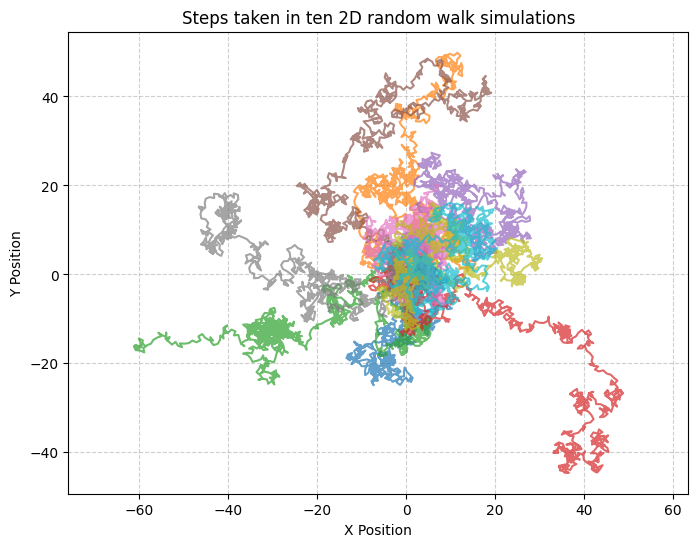

In [8]:
steps, trials = 1000, 10
rms_dist = mult_random_walk2d(steps,trials, plot = True)

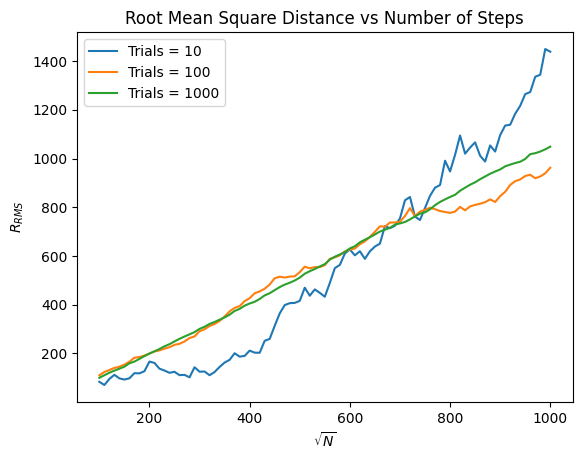

In [11]:
trials_list = [10, 100, 1000]
N_values = np.arange(100, steps+1, 10)

for trials in trials_list:
    rms_distances = []
    for N in N_values:
        rms_distances.append(mult_random_walk2d(N, trials, plot=False))
    plt.plot(N_values, rms_distances, label=f'Trials = {trials}')

plt.xlabel(r'$\sqrt{N}$')
plt.ylabel(r'$R_{RMS}$')
plt.title('Root Mean Square Distance vs Number of Steps')
plt.grid(False)
plt.legend()
plt.savefig("rmsplot")
plt.show()


## Task 2 Ising model 

### Periodic B.C. and Matrices/Neighbours setup

In [2]:
def per(i,N):
    if (i>=N):
        return (i-N)
    elif (i<0):
        return (i+N)
    else:
        return i
        
N, k = 50, 0
aux1 = np.zeros((N*N,2), dtype = int)     # the node          # Maps index to (i,j)
aux2 = np.zeros((N,N), dtype = int)       # the coordinates   # Maps (i,j) to index

for ix in range(N):
    for iy in range(N):
        aux1[k, 0] = ix
        aux1[k, 1] = iy
        aux2[ix, iy] = k
        k+=1

nn = np.zeros((N*N, 4), dtype = int) 

for k in range(N**2):
    ix, iy = aux1[k,0], aux1[k,1]

    nn[k,0] = aux2[per(ix-1, N), per(iy, N)]
    nn[k,1] = aux2[per(ix+1, N), per(iy, N)] 
    nn[k,2] = aux2[per(ix, N), per(iy-1, N)] 
    nn[k,3] = aux2[per(ix, N), per(iy+1, N)] 

### Hamiltonian / Energy calculation

In [3]:
from numba import njit
@njit 

def hamiltonian(S, nn, aux1, J, B):
    H = 0
    
    for i in range(nn.shape[0]):
        ix, iy = aux1[i]
        sum2 = 0
        for j in nn[i]:
            jx, jy = aux1[j]
            sum2 += S[jx, jy]
            
        H += -J/2 * S[ix, iy] * sum2 - B * S[ix, iy]  #divided by two due to double counting
    return H

### Metropolis and Model

In [4]:
from numba import njit
@njit

def metropolis_step(S, E, J, B, kT, nn, aux1):
    N = S.shape[0]
    
    r = np.random.randint(0, N * N)
    x, y = aux1[r]
    x = int(x)
    y = int(y)
    
    nn_sum = 0
    for k in nn[r]:
        i, j = aux1[k, 0], aux1[k, 1]
        nn_sum += S[i, j]
    
    dE = 2 * S[x, y] * (J * nn_sum + B)
    
    if dE < 0 or np.random.random() < np.exp(-dE / kT): 
        S[x, y] = -S[x, y]
        E += dE
    
    m = np.sum(S)
    
    return S, E, m

In [5]:
@njit

def ising_model(S, nn, aux1, n, N_skip, N_therm, J, B, kT):
    N = S.shape[0]
    steps = int(n * N * N / N_skip)

    E = hamiltonian(S, nn, aux1, J, B)
    m = np.sum(S)

    for _ in range(N_therm):
        S, E, m = metropolis_step(S, E, J, B, kT, nn, aux1)

    E_n = np.zeros(steps)
    M_n = np.zeros(steps)
    
    for i in range(steps):
        for _ in range(N_skip):
            S, E, m = metropolis_step(S, E, J, B, kT, nn, aux1)
        E_n[i] = E
        M_n[i] = m

    return S, E_n, M_n

### Case: b = 1

In [7]:
# Cold Start
S = np.ones((N, N))

# Model for J=1 and B=1
N = 50
J, B, n = 1, 1, 1000
N_skip = N * N
therm_num = N * N * 10
temperatures = np.linspace(0.8, 18, 250)

E_vals_b1 = []
M_vals_b1 = []
heatcap_vals_b1 = []
susc_vals_b1 = []

for kT in tqdm(temperatures):
    S, E_n, M_n = ising_model(S, nn, aux1, n, N_skip, therm_num, J, B, kT)

    M_n = M_n / (N * N)

    E_avg = np.mean(E_n) / (N * N)
    M_avg = np.mean(M_n)
    chi = np.var(M_n) / kT
    c = np.var(E_n) / (kT * kT * N * N)

    E_vals_b1.append(E_avg)
    M_vals_b1.append(M_avg)
    heatcap_vals_b1.append(c)
    susc_vals_b1.append(chi)

E_vals_b1 = np.array(E_vals_b1)
M_vals_b1 = np.array(M_vals_b1)
heatcap_vals_b1 = np.array(heatcap_vals_b1)
susc_vals_b1 = np.array(susc_vals_b1)

Tc_index_b1_susc = np.argmax(susc_vals_b1)
Tc_index_b1_hc = np.argmax(heatcap_vals_b1)

Tc_estimate_b1_susc = temperatures[Tc_index_b1_susc]
Tc_estimate_b1_hc = temperatures[Tc_index_b1_hc]

print(f"Estimated Tc based on magn. susceptibility ≈ {Tc_estimate_b1_susc:.3f}")
print(f"Estimated Tc based on heat capacity ≈ {Tc_estimate_b1_hc:.3f}")


100%|█████████████████████████████████████████| 250/250 [11:41<00:00,  2.81s/it]

Estimated Tc based on magn. susceptibility ≈ 4.599
Estimated Tc based on heat capacity ≈ 3.839


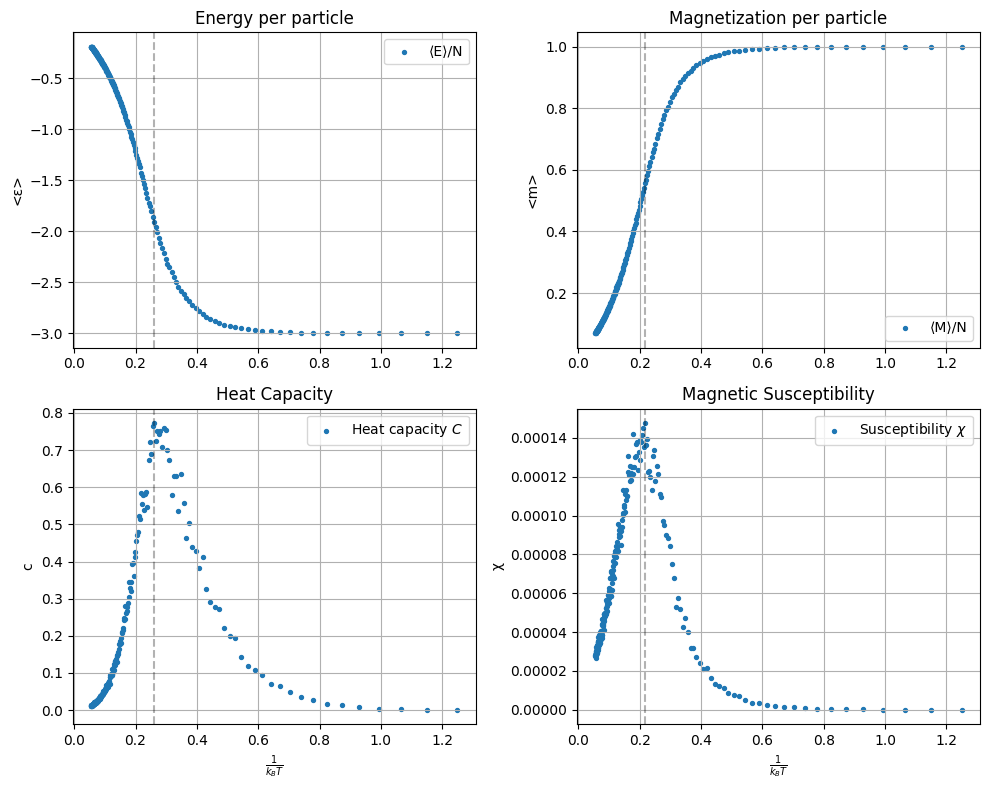

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
axvline_pos_1 = 0.2174
axvline_pos_2 = 0.2604

# Energy per spin
ax[0][0].scatter(1/temperatures, E_vals_b1, label='⟨E⟩/N', s=8)
ax[0][0].axvline(axvline_pos_2, ls='--', color='black', alpha=0.3)
ax[0][0].set_ylabel('<ε>')
ax[0][0].set_title('Energy per particle')
ax[0][0].grid(True)
ax[0][0].legend()

# Magnetization per spin
ax[0][1].scatter(1/temperatures, M_vals_b1, label='⟨M⟩/N', s=8)
ax[0][1].axvline(axvline_pos_1, ls='--', color='black', alpha=0.3)
ax[0][1].set_ylabel('<m>')
ax[0][1].set_title('Magnetization per particle')
ax[0][1].grid(True)
ax[0][1].legend()

# Heat capacity
ax[1][0].scatter(1/temperatures, heatcap_vals_b1, label='Heat capacity $C$', s=8)
ax[1][0].axvline(axvline_pos_2, ls='--', color='black', alpha=0.3)
ax[1][0].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][0].set_ylabel('c')
ax[1][0].set_title('Heat Capacity')
ax[1][0].grid(True)
ax[1][0].legend()

# Susceptibility
ax[1][1].scatter(1/temperatures, susc_vals_b1, label='Susceptibility $\\chi$', s=8)
ax[1][1].axvline(axvline_pos_1, ls='--', color='black', alpha=0.3)
ax[1][1].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][1].set_ylabel('χ')
ax[1][1].set_title('Magnetic Susceptibility')
ax[1][1].grid(True)
ax[1][1].legend()

plt.tight_layout()
plt.savefig("caseb1")
plt.show()

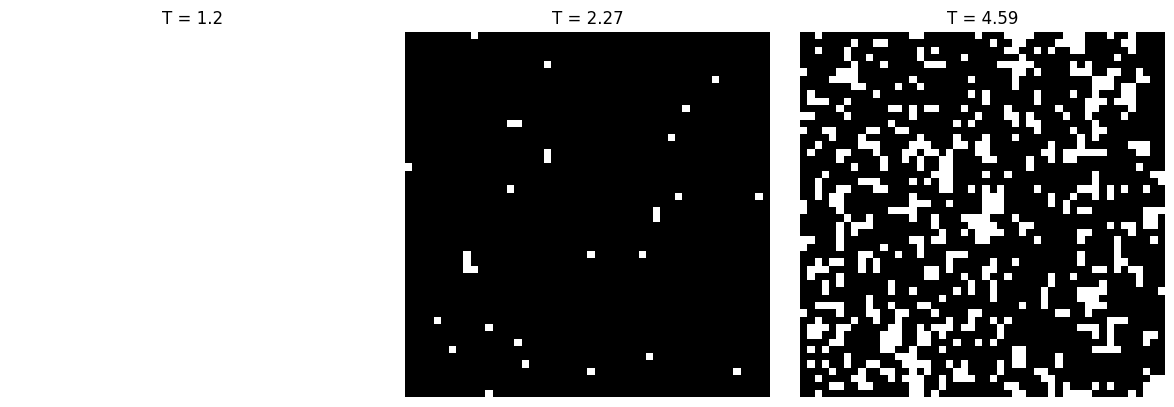

In [15]:
import matplotlib.pyplot as plt

temps = [1.2, 2.27, 4.59]  # T < Tc, T ≈ Tc, T > Tc

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, T in enumerate(temps):
    S = np.ones((N, N))
    E = hamiltonian(S, nn, aux1, J, B)
    
    # Thermalize
    for _ in range(N * N * 20):
        S, E, _ = metropolis_step(S, E, J, B, T, nn, aux1)
    
    axes[i].imshow(S.reshape(N,N), cmap='Greys')
    axes[i].set_title(f'T = {T}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### b = 0

In [17]:
# Cold Start
S = np.ones((N, N))

# Model for J=1 and B = 0
N = 50
J, B, n = 1, 0, 1000
N_skip = N * N
therm_num = N * N * 10
temperatures = np.linspace(0.6, 18, 250)

E_vals_b0 = []
M_vals_b0 = []
heatcap_vals_b0 = []
susc_vals_b0 = []

for kT in tqdm(temperatures):
    S, E_n, M_n = ising_model(S, nn, aux1, n, N_skip, therm_num, J, B, kT)

    M_n = M_n / (N * N)  

    E_avg = np.mean(E_n) / (N * N)
    M_avg = np.mean(M_n)
    chi = np.var(M_n) / kT
    c = np.var(E_n) / (kT * kT * N * N)

    E_vals_b0.append(E_avg)
    M_vals_b0.append(M_avg)
    heatcap_vals_b0.append(c)
    susc_vals_b0.append(chi)

E_vals_b0 = np.array(E_vals_b0)
M_vals_b0 = np.array(M_vals_b0)
heatcap_vals_b0 = np.array(heatcap_vals_b0)
susc_vals_b0 = np.array(susc_vals_b0)

Tc_index_b0_susc = np.argmax(susc_vals_b0)
Tc_index_b0_hc = np.argmax(heatcap_vals_b0)  # Fix this line

Tc_estimate_b0_susc = temperatures[Tc_index_b0_susc]
Tc_estimate_b0_hc = temperatures[Tc_index_b0_hc]

print(f"Estimated Tc based on magn. susceptibility ≈ {Tc_estimate_b0_susc:.3f}")
print(f"Estimated Tc based on heat capacity ≈ {Tc_estimate_b0_hc:.3f}")


100%|█████████████████████████████████████████| 250/250 [11:42<00:00,  2.81s/it]

Estimated Tc based on magn. susceptibility ≈ 2.417
Estimated Tc based on heat capacity ≈ 2.277


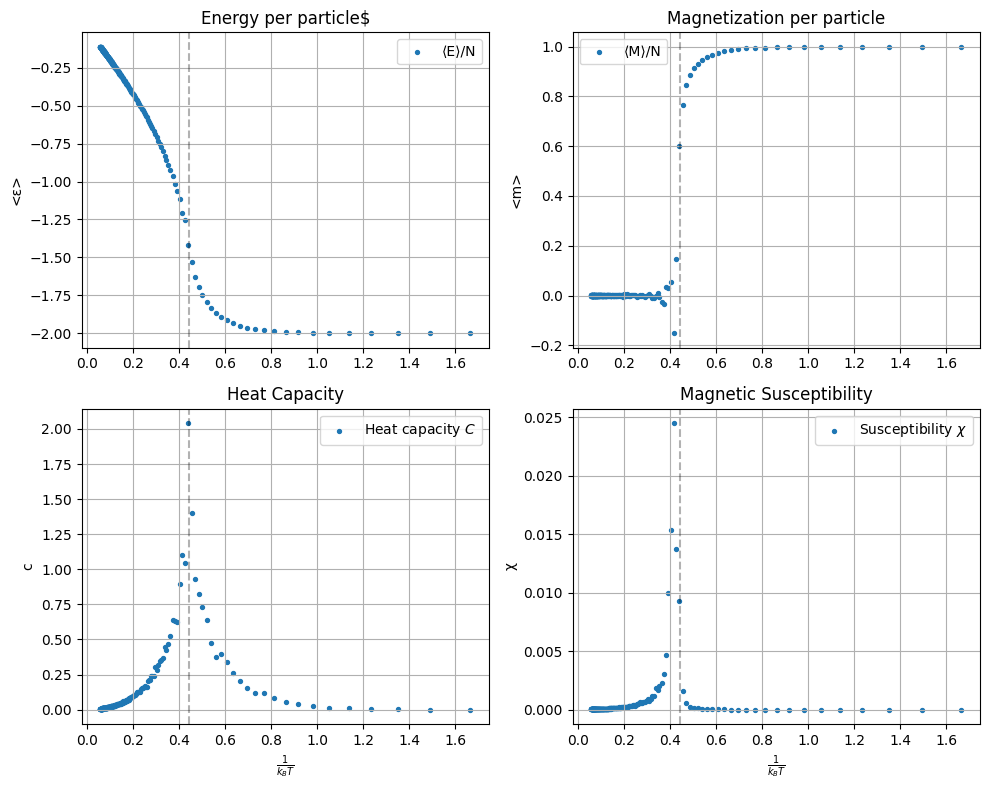

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
# Energy per spin
ax[0][0].scatter(1/temperatures, E_vals_b0, label='⟨E⟩/N', s = 8)
ax[0][0].axvline(0.4406,ls='--',color='black',alpha=0.3)
ax[0][0].set_ylabel('<ε>')
ax[0][0].set_title('Energy per particle$')
ax[0][0].grid(True)
ax[0][0].legend()

# Magnetization per spin
ax[0][1].scatter(1/temperatures, M_vals_b0, label='⟨M⟩/N', s = 8)
ax[0][1].axvline(0.4406,ls='--',color='black',alpha=0.3)
ax[0][1].set_ylabel('<m>')
ax[0][1].set_title('Magnetization per particle')
ax[0][1].grid(True)
ax[0][1].legend()

# Heat capacity
ax[1][0].scatter(1/temperatures, heatcap_vals_b0, label='Heat capacity $C$', s = 8)
ax[1][0].axvline(0.4406,ls='--',color='black',alpha=0.3)
ax[1][0].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][0].set_ylabel('c')
ax[1][0].set_title('Heat Capacity')
ax[1][0].grid(True)
ax[1][0].legend()

# Susceptibility
ax[1][1].scatter(1/temperatures, susc_vals_b0, label='Susceptibility $\\chi$', s = 8)
ax[1][1].axvline(0.4406,ls='--',color='black',alpha=0.3)
ax[1][1].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][1].set_ylabel('χ')
ax[1][1].set_title('Magnetic Susceptibility')
ax[1][1].grid(True)
ax[1][1].legend()

plt.tight_layout()
plt.savefig("casea1")
plt.show()

### kbtc

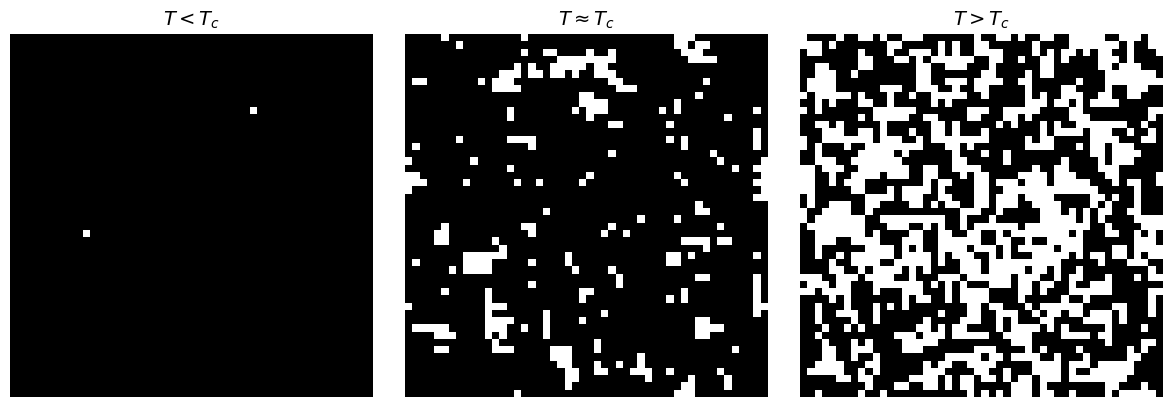

In [38]:
# Model for J=1 and B = 0
N = 50
J, B, n = 1, 0, 1000
N_skip = N * N
therm_num = N * N * 10

temps = [1.3, 2.27, 4.5]  # T < Tc, T ≈ Tc, T > Tc
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = [r"$T < T_c$", r"$T \approx T_c$", r"$T > T_c$"]

for i, T in enumerate(temps):
    S = np.ones((N, N))
    E = hamiltonian(S, nn, aux1, J, B)

    # Thermalize
    for _ in range(20 * N * N):
        S, E, _ = metropolis_step(S, E, J, B, T, nn, aux1)

    axes[i].imshow(S, cmap='Greys')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("confb0")
plt.show()



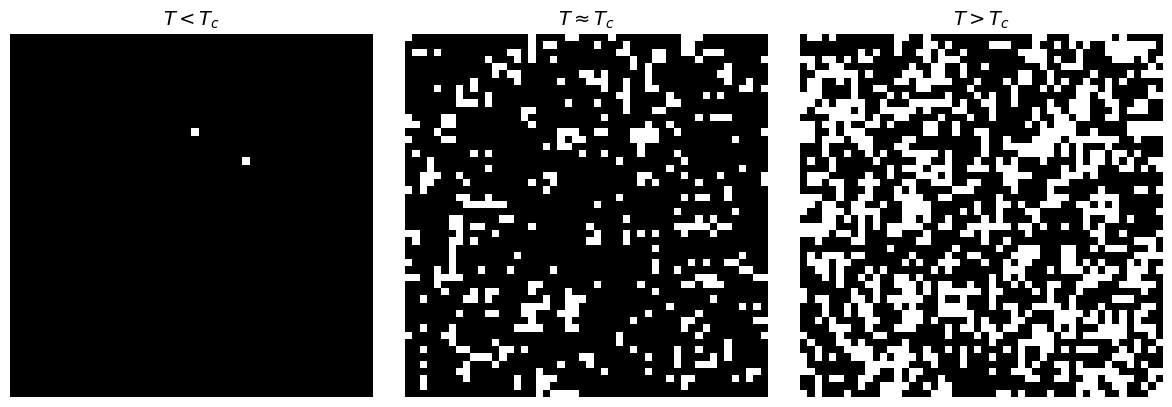

In [39]:
# Model for J=1 and B = 1
N = 50
J, B, n = 1, 1, 1000
N_skip = N * N
therm_num = N * N * 10

temps = [1.3, 3.9, 8]  # T < Tc, T ≈ Tc, T > Tc
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = [r"$T < T_c$", r"$T \approx T_c$", r"$T > T_c$"]

for i, T in enumerate(temps):
    S = np.ones((N, N))
    E = hamiltonian(S, nn, aux1, J, B)

    # Thermalize
    for _ in range(20 * N * N):
        S, E, _ = metropolis_step(S, E, J, B, T, nn, aux1)

    axes[i].imshow(S, cmap='Greys')
    axes[i].set_title(titles[i], fontsize=14)
    axes[i].axis('off')

plt.tight_layout()
plt.savefig("confb1")
plt.show()

A few issues occured in this cases below so I could not showcase the results

### J = -1 B = 0 issues


100%|█████████████████████████████████████████| 250/250 [11:11<00:00,  2.69s/it]


Estimated Tc (AFM) from susceptibility ≈ 2.976
Estimated Tc (AFM) from heat capacity ≈ 0.600


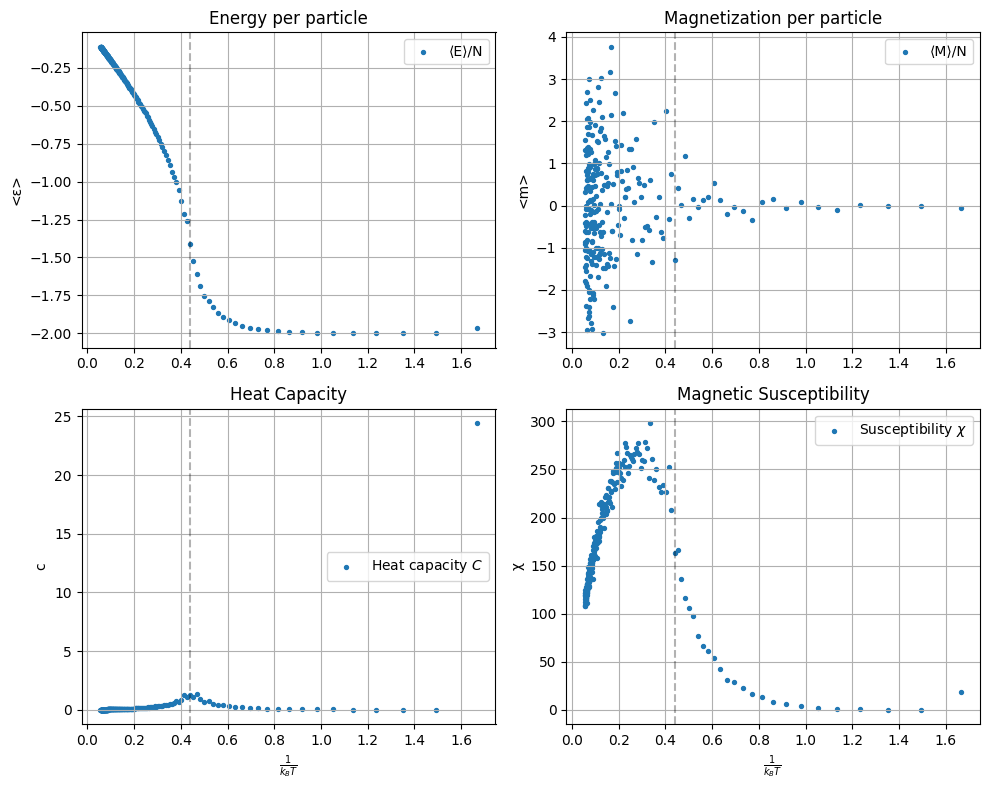

In [9]:
# Cold Start
S = np.ones((N, N))

# Model for J = -1 (Antiferromagnetic) and B = 0
N = 50
J, B, n = -1, 0, 1000
N_skip = N * N
therm_num = N * N * 10
temperatures = np.linspace(0.6, 18, 250)

E_vals_afm = []
M_vals_afm = []
heatcap_vals_afm = []
susc_vals_afm = []

for kT in tqdm(temperatures):
    S, E_n, M_n = ising_model(S, nn, aux1, n, N_skip, therm_num, J, B, kT)

    M_n = M_n  

    E_avg = np.mean(E_n) / (N * N)
    M_avg = np.mean(M_n)
    chi = np.var(M_n) / kT
    c = np.var(E_n) / (kT * kT * N * N)

    E_vals_afm.append(E_avg)
    M_vals_afm.append(M_avg)
    heatcap_vals_afm.append(c)
    susc_vals_afm.append(chi)

E_vals_afm = np.array(E_vals_afm)
M_vals_afm = np.array(M_vals_afm)
heatcap_vals_afm = np.array(heatcap_vals_afm)
susc_vals_afm = np.array(susc_vals_afm)

Tc_index_afm_susc = np.argmax(susc_vals_afm)
Tc_index_afm_hc = np.argmax(heatcap_vals_afm)

Tc_estimate_afm_susc = temperatures[Tc_index_afm_susc]
Tc_estimate_afm_hc = temperatures[Tc_index_afm_hc]

print(f"Estimated Tc (AFM) from susceptibility ≈ {Tc_estimate_afm_susc:.3f}")
print(f"Estimated Tc (AFM) from heat capacity ≈ {Tc_estimate_afm_hc:.3f}")

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Energy per spin
ax[0][0].scatter(1/temperatures, E_vals_afm, label='⟨E⟩/N', s=8)
ax[0][0].axvline(0.4406, ls='--', color='black', alpha=0.3)
ax[0][0].set_ylabel('<ε>')
ax[0][0].set_title('Energy per particle')
ax[0][0].grid(True)
ax[0][0].legend()

# Magnetization per spin
ax[0][1].scatter(1/temperatures, M_vals_afm, label='⟨M⟩/N', s=8)
ax[0][1].axvline(0.4406, ls='--', color='black', alpha=0.3)
ax[0][1].set_ylabel('<m>')
ax[0][1].set_title('Magnetization per particle')
ax[0][1].grid(True)
ax[0][1].legend()

# Heat capacity
ax[1][0].scatter(1/temperatures, heatcap_vals_afm, label='Heat capacity $C$', s=8)
ax[1][0].axvline(0.4406, ls='--', color='black', alpha=0.3)
ax[1][0].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][0].set_ylabel('c')
ax[1][0].set_title('Heat Capacity')
ax[1][0].grid(True)
ax[1][0].legend()

# Susceptibility
ax[1][1].scatter(1/temperatures, susc_vals_afm, label='Susceptibility $\\chi$', s=8)
ax[1][1].axvline(0.4406, ls='--', color='black', alpha=0.3)
ax[1][1].set_xlabel(r'$\frac{1}{k_BT}$')
ax[1][1].set_ylabel('χ')
ax[1][1].set_title('Magnetic Susceptibility')
ax[1][1].grid(True)
ax[1][1].legend()

plt.tight_layout()
plt.savefig("case_afm")
plt.show()
